In [1]:
import tensorflow as tf
import json
import os

from core.data  import finetuning_records
from core.astromer import get_ASTROMER, get_FINETUNING, train
from tensorflow.keras import Model
import matplotlib.pyplot as plt
# from matplotlib import rc
# rc('text', usetex=True)

plt.style.use('dark_background')

%load_ext autoreload
%autoreload 2

In [7]:
exp_path = './experiments/debug/'
conf_file = os.path.join(exp_path, 'conf.json')

with open(conf_file, 'r') as handle:
    conf = json.load(handle)
conf

{'max_obs': 50,
 'data': './data/records/macho',
 'p': './experiments/debug',
 'batch_size': 256,
 'epochs': 2000,
 'patience': 2000,
 'finetuning': False,
 'repeat': 1,
 'layers': 2,
 'heads': 2,
 'head_dim': 106,
 'dff': 256,
 'dropout': 0.1,
 'base': 1000,
 'lr': 0.001}

In [21]:
train_batches = finetuning_records(os.path.join(conf['data'], 'train'), 
                            conf['batch_size'], 
                            max_obs=conf['max_obs'])
# val_batches = load_records(os.path.join(conf['data'], 'val'), 
#                             conf['batch_size'], 
#                             input_len=conf['max_obs'],
#                             finetuning=conf['finetuning'],
#                           repeat=5)
# test_batches = load_records(os.path.join(conf['data'], 'val'), 
#                             conf['batch_size'], 
#                             input_len=conf['max_obs'],
#                             finetuning=conf['finetuning'])

In [22]:
for batch in train_batches:
    print(batch['label'])
    break

tf.Tensor(
[4 4 0 2 6 4 4 3 0 6 4 6 3 2 6 0 2 6 6 6 2 5 4 2 6 6 1 3 4 5 6 4 3 4 4 4 3
 4 0 3 3 6 2 2 1 6 3 3 6 1 1 4 3 5 1 2 6 1 4 4 6 6 4 4 2 3 4 6 3 3 6 4 2 4
 1 0 6 3 5 3 6 4 2 4 6 3 6 6 3 6 4 1 3 6 4 6 5 6 2 6 4 6 6 4 4 6 2 3 3 6 4
 6 6 4 4 3 3 6 4 3 2 6 3 3 3 6 3 2 3 4 4 4 6 2 0 6 6 6 3 6 6 3 3 1 6 2 4 0
 1 1 6 4 2 0 4 3 3 4 3 2 4 0 2 4 4 0 2 3 6 6 0 1 6 2 2 4 4 2 3 6 0 4 4 4 3
 6 4 6 6 6 4 3 4 0 4 6 6 3 3 2 2 6 4 4 6 2 1 6 6 3 2 2 6 6 2 1 4 3 6 4 0 4
 3 6 6 2 0 6 4 6 4 4 6 4 4 4 6 2 2 6 0 2 6 6 4 6 4 5 6 4 6 0 4 1 4 4], shape=(256,), dtype=int32)


In [23]:
astromer = get_ASTROMER(num_layers=conf['layers'],
                        d_model=conf['head_dim'],
                        num_heads=conf['heads'],
                        dff=conf['dff'],
                        base=conf['base'],
                        dropout=conf['dropout'],
                        maxlen=conf['max_obs'])

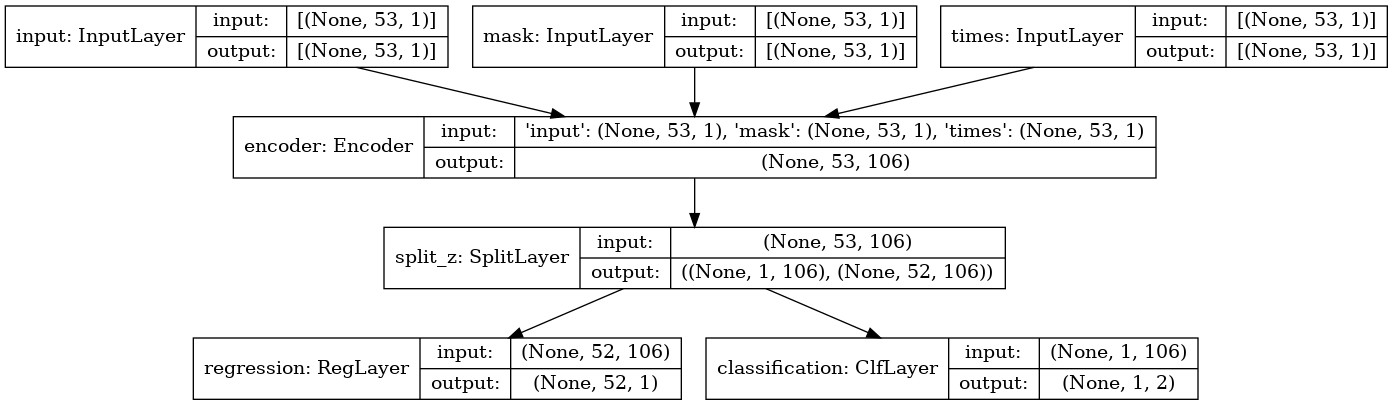

In [24]:
tf.keras.utils.plot_model(astromer, show_shapes=True)

In [68]:
uniques, _ = tf.unique([b['label']for b in test_batches.unbatch()])
num_cls = uniques.shape[0]

In [69]:
finetuning = get_FINETUNING(astromer, num_cls=num_cls)

In [70]:
weights_path = '{}/finetuning/weights'.format(conf['p'])
finetuning.load_weights(weights_path)

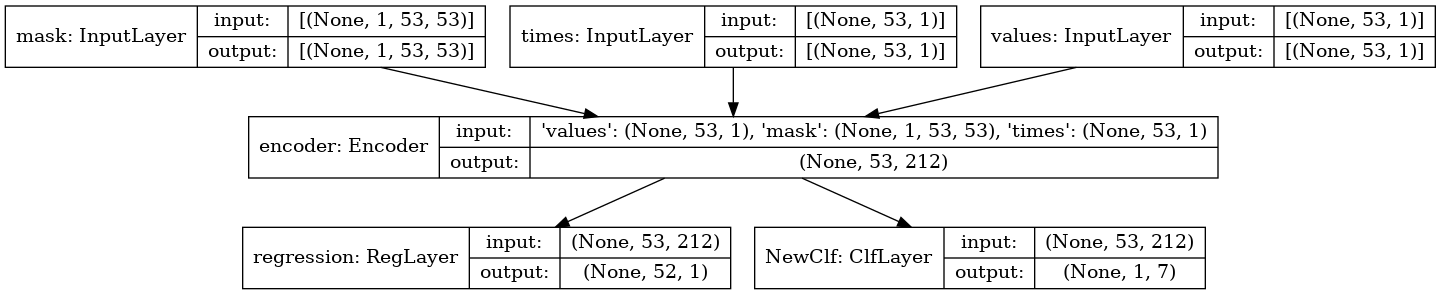

In [71]:
tf.keras.utils.plot_model(finetuning, show_shapes=True)

In [72]:
encoder = finetuning.get_layer('encoder')
attention = Model(inputs=encoder.input,
                  outputs=encoder.output,
                  name="FINETUNING")

In [73]:
def get_encoding(model, batches):
    encoding = []
    y_true   = []
    for batch in batches:
        inputs, target = input_format(batch, use_random=False, finetuning=True)
        true = tf.slice(target['y_true'], [0,0,0], [-1,-1,1])
        output = model(inputs)
        y_true.append(true)
        encoding.append(output)
    y_true = tf.concat(y_true, 0)
    output = tf.concat(encoding, 0)   
    return tf.reshape(y_true, [-1, 1]), tf.reduce_mean(output, 2)

In [74]:
y_train, x_train = get_encoding(attention, train_batches)

In [75]:
y_val, x_val = get_encoding(attention, val_batches)

In [76]:
y_test, x_test = get_encoding(attention, test_batches)

In [77]:
from sklearn.ensemble import RandomForestClassifier

In [78]:
clf = RandomForestClassifier(n_estimators=1000, max_depth=None, random_state=0, class_weight='balanced')

In [79]:
clf = clf.fit(x_train, y_train)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


In [80]:
y_test_pred = clf.predict(x_test)

In [81]:
from sklearn.metrics import precision_recall_fscore_support

In [82]:
prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_test_pred, average='macro')

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [83]:
from sklearn.metrics import confusion_matrix

In [86]:
cm = confusion_matrix(y_test, y_test_pred)

In [87]:
import pandas as pd 

In [91]:
display_labels = pd.read_csv('./data/records/macho/objects.csv')['label'].values

In [92]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=display_labels)

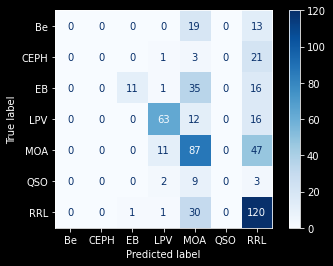

In [94]:
fig, ax = plt.subplots(1,1)
# NOTE: Fill all variables here with default values of the plot_confusion_matrix
disp = disp.plot(cmap='Blues', ax=ax)

plt.show()